In [1]:
# basic imports
import numpy as np
import pandas as pd
from time import time
from os.path import exists, join

# plotting and visualization
from nilearn import datasets
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt

# for ML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(1679838)
torch.manual_seed(1679838)

C:\ProgramData\Anaconda3\envs\SLHaka\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_path = join(".", "data") if exists(join(".", "data")) \
    else join("..", "input", "statistical-learning-sapienza-spring-2021")

In [3]:
train = pd.read_csv(join(data_path, 'train.csv'))
test = pd.read_csv(join(data_path, 'test.csv'))

### Splitting

In [4]:
train_split, val_split = train_test_split(train, test_size=0.0333, random_state=42)

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)

In [5]:
def get_data(entry):
    variables = entry[['var1', 'var2', 'var3']].replace({"A": 0, "C": 1}).to_numpy()
    timeseries = entry[5 if "y" in entry.index else 4:].to_numpy(dtype=float).reshape((115, 116), order="F")
    return {"variables": variables, "timeseries": timeseries}

train_timeseries = train_split.apply(lambda row: get_data(row)["timeseries"], axis=1).to_list()
val_timeseries = val_split.apply(lambda row: get_data(row)["timeseries"], axis=1).to_list()
train_variables = train_split.apply(lambda row: get_data(row)["variables"], axis=1).to_list()
val_variables = val_split.apply(lambda row: get_data(row)["variables"], axis=1).to_list()

test_timeseries = test.apply(lambda row: get_data(row)["timeseries"], axis=1).to_list()
test_variables = test.apply(lambda row: get_data(row)["variables"], axis=1).to_list()

## Correlation matrices and PCA

In [6]:
def apply_connectivity(time_series, vect=True, diag=True):
    # objects:
    correlation_measure = ConnectivityMeasure(kind="tangent",  # 'partial correlation',
                                              vectorize = vect,
                                              discard_diagonal=diag)
    pca_model = KernelPCA(kernel='rbf', n_components=16)

    # fitting predicting:
    cor_mat = correlation_measure.fit_transform(time_series)
    # pca_model.fit(cor_mat)
    reduced_cor = pca_model.fit_transform(cor_mat)
    return pd.DataFrame(reduced_cor).add_prefix('cor_')

train_cor_vec = apply_connectivity(train_timeseries)
val_cor_vec = apply_connectivity(val_timeseries)

test_cor_vec = apply_connectivity(test_timeseries)

In [7]:
train_var_and_cor = pd.concat([pd.DataFrame(train_variables).add_prefix('var_'), train_cor_vec], axis=1)
val_var_and_cor = pd.concat([pd.DataFrame(val_variables).add_prefix('var_'), val_cor_vec], axis=1)

test_var_and_cor = pd.concat([pd.DataFrame(test_variables).add_prefix('var_'), test_cor_vec], axis=1)

### Data loaders

In [8]:
def get_dataloader(timeseries, variables_correlation, labels):
    return DataLoader(TensorDataset(torch.Tensor(timeseries),torch.Tensor(variables_correlation),
                                    torch.Tensor(labels)), batch_size=20) # create your dataloader

train_dataloader = get_dataloader(train_timeseries, train_var_and_cor.to_numpy(), train_split.y.to_numpy())
val_dataloader = get_dataloader(val_timeseries, val_var_and_cor.to_numpy(), val_split.y.to_numpy())

## Model

In [29]:
class BlackEmbedding(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.rnn_model = nn.RNN(input_size=116, hidden_size=hidden_size, num_layers=num_layers, dropout=0.005, batch_first=True)

        self.fc1 = nn.Sequential(nn.Linear(3+16+(hidden_size*(1+num_layers)), 32),
                                 nn.ReLU())
                                 # nn.Dropout(0.01))
        self.fc2 = nn.Sequential(nn.Linear(32, 32),
                                 nn.ReLU())
                                 # nn.Dropout(0.005))

        self.regressor = nn.Linear(32, 1)

    def forward(self, x, var_and_cor, predict_anyway=False):
        # var_and_cor = var_and_cor[:, :3]

        # time series:
        outputs, hidden = self.rnn_model(x)
        hidden = torch.cat(list(map(lambda i: hidden[i, ], range(hidden.shape[0]))), dim=-1)

        x = torch.cat([var_and_cor, outputs[:, -1, ], hidden], dim=-1)  # taking only the last

        x = self.fc1(x)
        x = self.fc2(x)

        if self.training or predict_anyway:
            x = self.regressor(x)

        return x.squeeze(dim=1)

model = BlackEmbedding(hidden_size=64, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 12, 40], gamma=0.9)
criterion = nn.MSELoss()

## Training

In [30]:
epocs = 70
validate = True
rmse = {"train": [], "val": []}
best = {"loss": None, "state_dict": None}

start = time()
for epoch in range(epocs):
    model.train()
    rmse["train"].append(0)
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, var_and_cor, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs, var_and_cor)

        # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        rmse["train"][epoch] += (loss.sqrt().mean(dim=0)/len(train_dataloader)).item()

    print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {rmse['train'][epoch]}")
    # validation
    if validate:
        model.eval()

        rmse["val"].append(0)
        for i, data in enumerate(val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, var_and_cor, labels = data
            with torch.no_grad():
                outputs = model(inputs, var_and_cor, predict_anyway=True)

            # forward + backward + optimize
            rmse["val"][epoch] += (criterion(outputs, labels).sqrt().mean(dim=0)/len(val_dataloader)).item()

        print(f"    Val   RMSE loss: {rmse['val'][epoch]}")

        # check for overfitting:
        if len(rmse["val"]) > 4 and all(map(lambda x: x[0]<x[1], zip(rmse["val"][-4:-1], rmse["val"][-3:]))):
            break

        if best["loss"] is None or best["loss"] > rmse["val"][epoch]:
            best["loss"] = rmse["val"][epoch]
            best["state_dict"] = model.state_dict()

    # scheduler.step()

print('\n\n****************** Finished Training ******************')
print("seconds elapsed: ", time()-start)



------> Epoch 1 <------
    Train RMSE loss: 109.03999042510986
    Val   RMSE loss: 107.3597640991211

------> Epoch 2 <------
    Train RMSE loss: 101.13809847831726
    Val   RMSE loss: 92.09324645996094

------> Epoch 3 <------
    Train RMSE loss: 74.80802083015442
    Val   RMSE loss: 54.28483963012695

------> Epoch 4 <------
    Train RMSE loss: 34.50653499364853
    Val   RMSE loss: 19.818279266357422

------> Epoch 5 <------
    Train RMSE loss: 18.564527213573456
    Val   RMSE loss: 18.640655517578125

------> Epoch 6 <------
    Train RMSE loss: 18.467590540647507
    Val   RMSE loss: 18.16800308227539

------> Epoch 7 <------
    Train RMSE loss: 17.61947214603424
    Val   RMSE loss: 17.666427612304688

------> Epoch 8 <------
    Train RMSE loss: 17.13859537243843
    Val   RMSE loss: 17.30324363708496

------> Epoch 9 <------
    Train RMSE loss: 17.02143207192421
    Val   RMSE loss: 16.90299415588379

------> Epoch 10 <------
    Train RMSE loss: 16.339134991168976


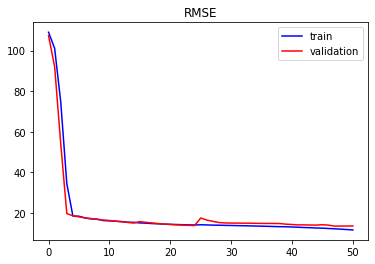

In [32]:
plt.plot(range(len(rmse["train"])), rmse["train"], color="blue", label="train")
plt.plot(range(len(rmse["val"])), rmse["val"], color="red", label="validation")
plt.title("RMSE")
plt.legend()
plt.show()

In [33]:
model.load_state_dict(best["state_dict"])

<All keys matched successfully>

# On test dataset

In [34]:
test_pred = model.forward(torch.Tensor(test_timeseries), torch.Tensor(test_var_and_cor.to_numpy()), predict_anyway=True)

In [35]:
submission_df = pd.DataFrame(index=test.index, columns=["id", "target"])
submission_df.id = test.id
submission_df.target = test_pred.detach().numpy()

In [36]:
submission_df.to_csv("RNN_submission.csv", index=False)
